In this notebook I will determine the mach numbers from the mach probe raw data.

# Mach probe overview

## Mach probe tip

The image below shows a drawing of the mach probe tip. The tip consists of a floating plate (F), a left plate (L), and a right plate (R). L and R are on opposite sides of the stem.

F is unbiased and should go to floating potential once inserted in the plasma.
L and R are biased negatively to the floating potential so that their voltage is in the ion saturation current regime.

![mach probe drawing](mach_probe_drawing.png)

## Mach Probe Wiring

The figure below shows the wiring of the mach probe for the shots scanning the $z = 0.4m$ plane.
We see that F is effectivly flaoting, connected through a high impedance voltage divide to gorund so the floating potential could be measured. L and R are biased negativly (sign of battery should be reversed) to the floating potential so that they are in the ion saturation current regime.

The L and R current monitors are being digitized on channels \j_008_014 and \j_008_015.

The current through L and R are measured with Pearson 411 current monitors. Both current monitors are 1 V/A.
The 411 current monitos have a 3db low frequency cutoff at $140Hz$. The equivalent time period $1/140Hz \approx 7ms$ is one the same order as the $\sim 3.5 ms$ sampling time, so there will be significant droop.

Jason noticed that there was droop on the current factors and noted that if he added the integral of the measured signal times a calibration factor the droop could be removed.
$V=V_{measured} + \int{V_{measured} dt} \cdot C$
This is noted in script pro00800.pro.
However, he later abandonded this apporach probabbly because he was not aware that the droop was caused by the passband of the current monitors.
The calibration factor $C$ is 0.8 for the L current monitor (Serial # 15946) and 0.7 for the R current monitor (Serial # 6593).

![wiring of probes](mach_probe_wiring.png)

## Mach probe data analysis

## Load Libraries

In [1]:
%matplotlib inline
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')
import MDSplus as mds

/Users/vonderlinden2/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Load a sample shot

Get data from MDS+ tree.
The z=0.4m scan is shotset 13. shots: 16690-16725 and 16863-16998 with bad shots 16864, 16906, 16907, and 16908.

In [2]:
shot = 16880

In [3]:
rsx_tree = mds.Tree('rsx', shot)
machR_node = rsx_tree.getNode('\j_008_014')
machL_node = rsx_tree.getNode('\j_008_015')
machR_data = machR_node.getData() 
machL_data = machL_node.getData()
machR = np.asarray(machR_data.getValue())
machL = np.asarray(machL_data.getValue())
machR_time = np.asarray(machR_data.getDimensions()[0])*1e-3
machL_time = np.asarray(machL_data.getDimensions()[0])*1e-3

## Plot sample data

Plot of data. The plasma occurs around 1.8ms. The oscillations starting at 2ms indicate the quiescent phase of flux rope rotation.

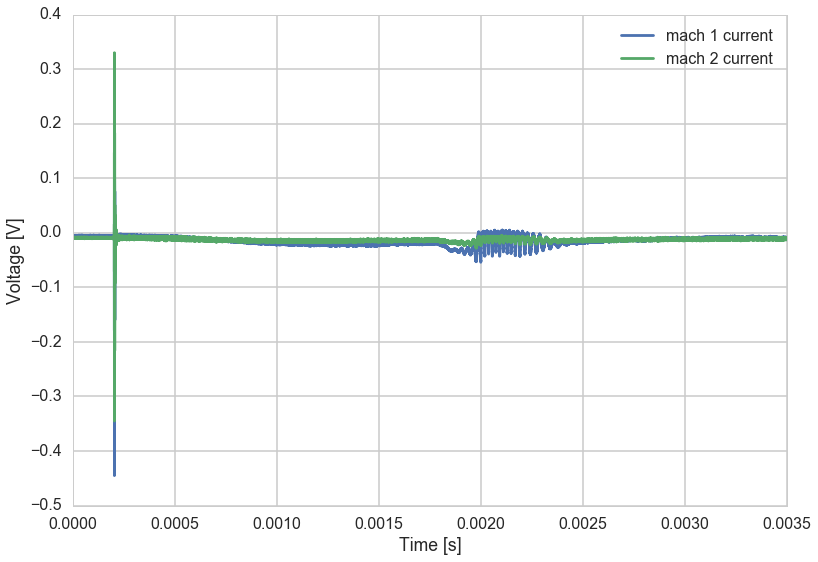

In [4]:
plt.plot(machR_time, machR, label='mach 1 current')
plt.plot(machL_time, machL, label='mach 2 current')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend()
plt.show()

## Symlog plot of data

Reviewing the data in a symlog plot to see more of the features. Sym log is linear close to zero and then logarithmic so that negative data can be displayed.

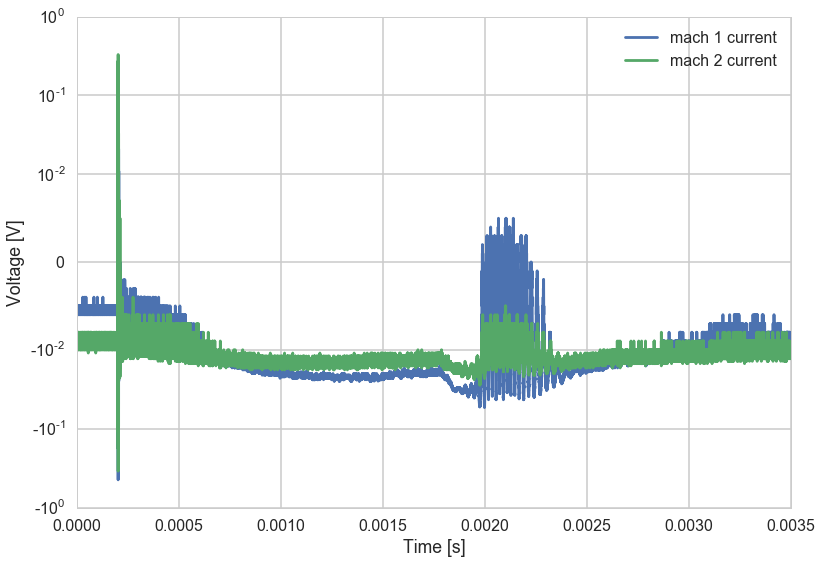

In [5]:
plt.plot(machR_time, machR, label='mach 1 current')
plt.plot(machL_time, machL, label='mach 2 current')
plt.yscale('symlog', linthreshy=0.01)
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend()
plt.show()

## Look at preshot

The preshot signal can be taken to last until $150 \mu s$. I will have to check how this varies shot to shot.

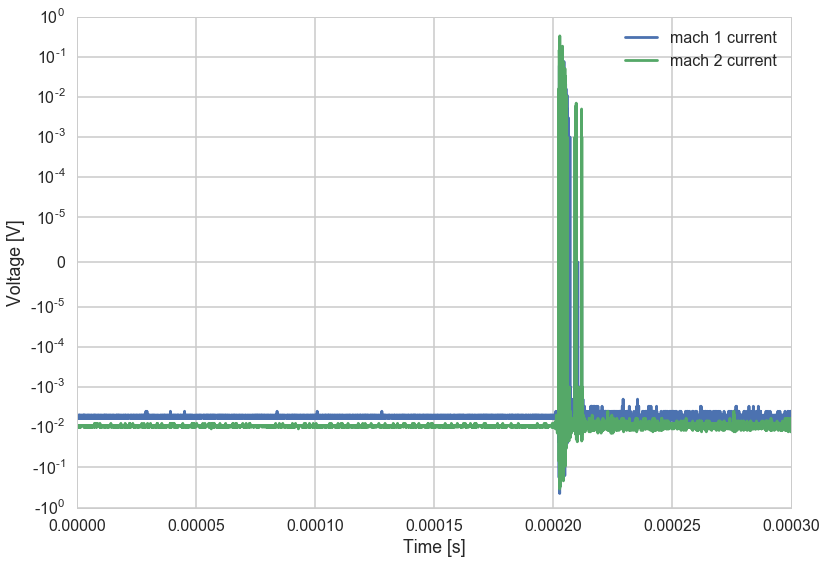

In [6]:
plt.plot(machR_time, machR, label='mach 1 current')
plt.plot(machL_time, machL, label='mach 2 current')
plt.xlim((0, 0.0003))
plt.yscale('symlog', linthreshy=0.00001)
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend()
plt.show()

## Remove offset

Remove offset in measurements. Jason removes the offset my taking the first datapoint and subtracting it from the rest of the signal. I will take an average of all pre-shot values as the offset and take the standard deviation as noise.

In [7]:
machR_jason_no_offset = machR - machR[0]
machL_jason_no_offset = machL - machL[0]

In [8]:
np.where(machR_time < 1.5e-4)[-1][-1]

2999

In [9]:
machR_no_offset = machR - np.mean(machR[:2999])
machL_no_offset = machL - np.mean(machL[:2999])

The apporaches do not yield much difference but we can now use the standard deviation of the signal as one part of the noise.

In [10]:
print 'ratio of mach R offsets', np.mean(machR[:2999])/machR[0]
print 'ratio of mach L offsets', np.mean(machL[:2999])/machL[0]

ratio of mach R offsets 1.06789
ratio of mach L offsets 1.01556


In [11]:
print 'std of Mach R pre-shot',  machR[:2999].std()
print 'std of Mach R pre-shot', machL[:2999].std()

std of Mach R pre-shot 0.000478425
std of Mach R pre-shot 0.000424013


## Remove Droop

When Jason determined the calibration factor he integrated by simply summing the measurements and mutiplying by the time step. This is equivalent to trapezoidal integration except for mutiplication of the last and first measurements by 0.5. Also Jason left the time in ms instead of converting to seconds.
To remove the droop I will use Jason's integration procedure and mutiply by $10^{3}$ so I can use his calibration factors.
$V=V_{measured} + \int{V_{measured} dt} \cdot C$

In [12]:
dt = machR_time[1] - machR_time[0]
machR_integral = np.cumsum(machR_no_offset)*dt*1e3
machR_corrected = machR_no_offset + machR_integral*0.7

dt = machL_time[1] - machL_time[0]
machL_integral = np.cumsum(machL_no_offset)*dt*1e3
machL_corrected = machL_no_offset + machL_integral*0.8

In the plot below we see that the droop correction shifts both signals negative. Which will allow us to take the logarithm to determine the mach number. 

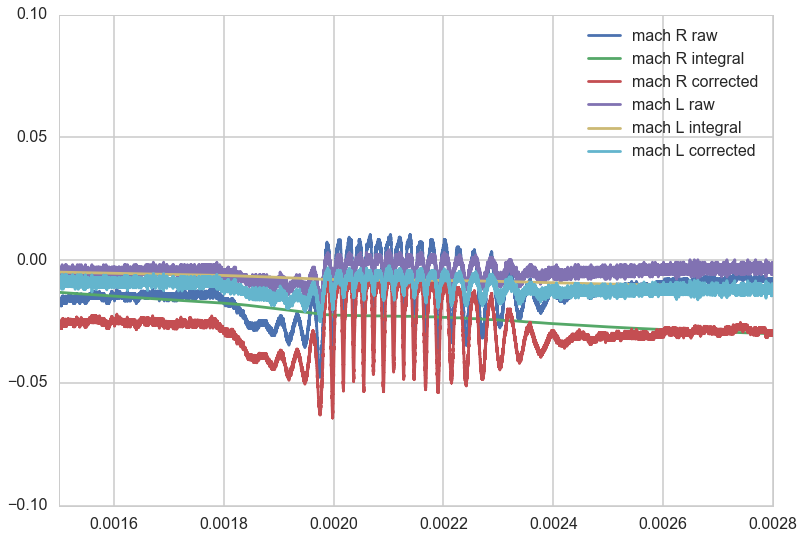

In [13]:
plt.plot(machR_time, machR_no_offset, label='mach R raw')
plt.plot(machR_time, machR_integral, label='mach R integral')
plt.plot(machR_time, machR_corrected, label='mach R corrected')

plt.plot(machL_time, machL_no_offset, label='mach L raw')
plt.plot(machL_time, machL_integral, label='mach L integral')
plt.plot(machL_time, machL_corrected, label='mach L corrected')


plt.legend()
plt.xlim((0.0015, 0.0028))
plt.ylim((-0.1, 0.1))
plt.show()

## Determine mach number M(t)

The mach number $M$ can be determine from:
$M = log(\frac{V_{R}}{V_{L}}) \cdot C$
Factor C is given in Hutchinson as 0.45 for low temperature plasma.
Several papers suggest more nuanced values for C depending on parameters.

In [14]:
mach = np.log(machL_corrected/machR_corrected)*0.45

In [15]:
np.sum(np.isnan(mach))

4265

### Plot of M(t)

This includes non plasma times.

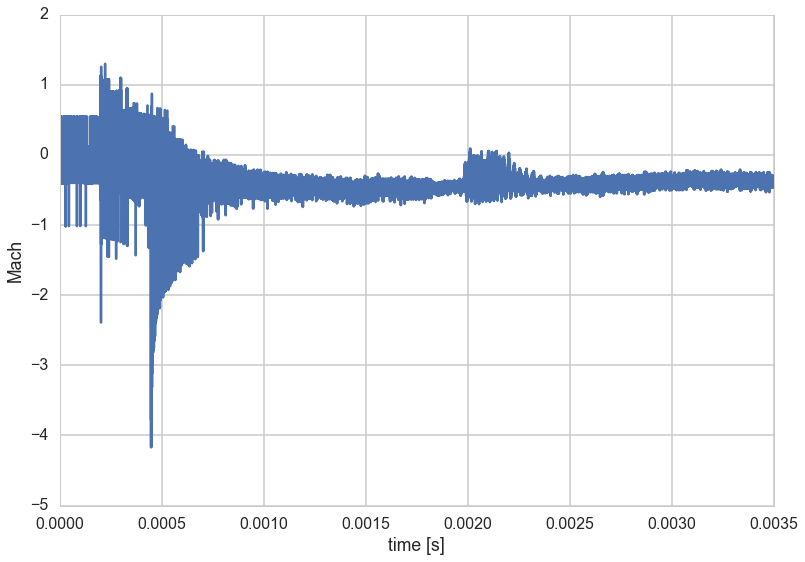

In [16]:
plt.plot(machR_time, mach)
plt.xlabel('time [s]')
plt.ylabel('Mach')
plt.show()

### Zoom in on plasma time

Below is a plot of just plasma time.

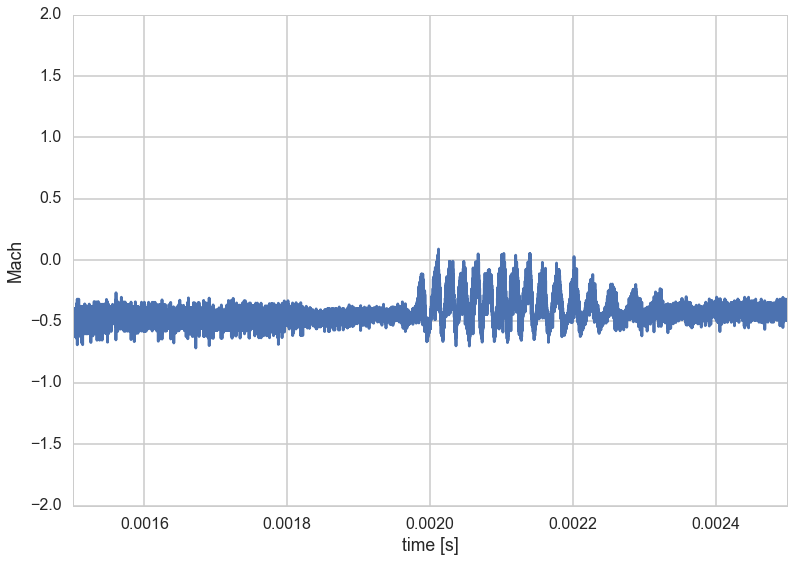

In [17]:
plt.plot(machR_time, mach)
plt.xlim((0.0015, 0.0025))
plt.ylim((-2, 2))
plt.xlabel('time [s]')
plt.ylabel('Mach')
plt.show()

## A look at mach data in sav files

In [18]:
import scipy.io.idl as idl

In [19]:
mach_y_dict = idl.readsav('/Users/vonderlinden2/rsx_drive/RSX/Analysis/1130517/003/113051763560.sav')

In [20]:
mach_y_dict.keys()

['x_out', 'delays', 'y_out', 'a_out']

In [21]:
mach_y_dict['delays']

array([ 0.        ,  0.1       ,  0.2       ,  0.30000001,  0.40000001,
        0.5       ,  0.60000002,  0.69999999,  0.80000001,  0.89999998,  1.        ], dtype=float32)

In [22]:
mach_y_dict['x_out']

array([ 0.05 ,  0.045,  0.04 ,  0.035,  0.03 ,  0.015,  0.01 ,  0.005,
        0.   , -0.005, -0.01 , -0.015, -0.025, -0.03 , -0.035, -0.04 ,
       -0.045, -0.05 , -0.05 , -0.045, -0.04 , -0.035, -0.03 , -0.025,
       -0.02 , -0.015, -0.01 , -0.005,  0.   ,  0.005,  0.01 ,  0.015,
        0.02 ,  0.025,  0.03 ,  0.035,  0.04 ,  0.045,  0.05 , -0.05 ,
       -0.045, -0.04 , -0.035, -0.03 , -0.025, -0.02 , -0.015, -0.01 ,
       -0.005,  0.   ,  0.005,  0.01 ,  0.015,  0.02 ,  0.025,  0.03 ,
        0.035,  0.04 ,  0.045,  0.05 ,  0.025,  0.02 , -0.02 , -0.05 ,
       -0.045, -0.04 , -0.035, -0.03 , -0.025, -0.02 , -0.015, -0.01 ,
       -0.005,  0.   ,  0.005,  0.01 ,  0.015,  0.02 ,  0.025,  0.03 ,
        0.035,  0.04 ,  0.045,  0.05 ], dtype=float32)

In [23]:
mach_y_dict['a_out'][7]

array([ 0.19882479,  0.2184785 ,  0.18245928,  0.27856761,  0.31191623,
        0.31191623,  0.67683476,  0.67683476,  0.98875105,  0.9357487 ,
        0.98875105,  0.62383246,  0.67683476,  0.62383246,  0.49437553,
        0.36491856,  0.49437553,  0.31191623,  0.26450396,  0.26450396,
        0.49437553,  0.36491856,  0.44137314,  0.67683476,  0.67683476,
        0.9357487 ,  0.76713657,  1.03616321,         inf,  0.80629176,
               inf,  0.98875105,  0.54178774,  0.49437553,  0.27276111,
        0.38128403,  0.19882479,  0.2184785 ,  0.16547617,  0.49437553,
        0.41233078,  0.36491856,  0.36491856,  0.62383246,  0.49437553,
        0.25182706,  1.03616321,         inf,         inf,         inf,
        1.03616321,  0.67683476,  0.38128403,  0.31191623,  0.35480583,
        0.27276111,  0.27856761,  0.31191623,  0.16547617,  0.12945697,
        0.31191623,  0.39396095,  0.67683476,  0.31191623,  0.31191623,
        0.15141253,  0.31191623,  0.41233078,  0.41233078,  0.54

In [37]:
to_remove = np.where(np.invert(np.isfinite(mach_y_dict['a_out'][7])))

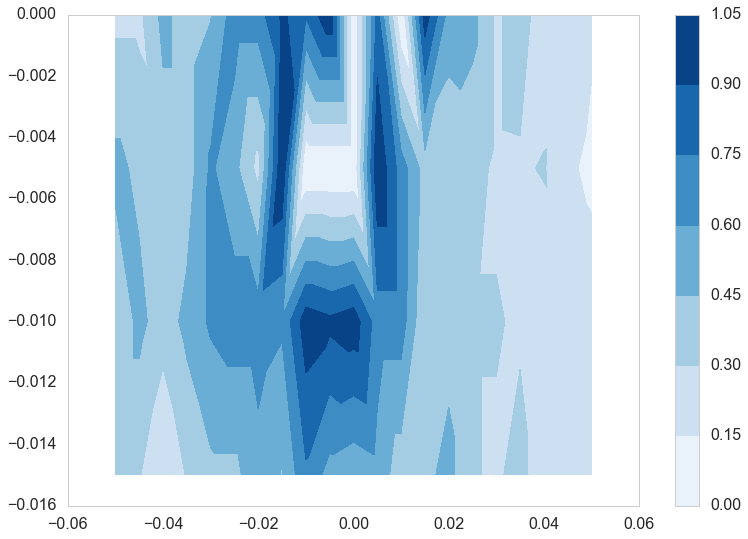

In [39]:
plt.tricontourf(np.delete(mach_y_dict['x_out'], to_remove), 
                np.delete(mach_y_dict['y_out'], to_remove), 
                np.delete(mach_y_dict['a_out'][7], to_remove),
                cmap=plt.get_cmap('Blues'))
plt.grid('off')
plt.colorbar()